In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR
from childes_mi.utils.general import flatten,save_fig

In [3]:
from childes_mi.information_theory import model_fitting as mf

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
MI_DF = pd.read_pickle(DATA_DIR/'mi/childes_mi.pickle')

In [6]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_words,n_unique_words
0,"[6.0615547382637684, 5.953026573946322, 5.8999...","[0.06497202939114834, 0.06421181443545038, 0.0...","[5.79799893493386, 5.805771966570329, 5.792474...","[0.06474471004074468, 0.06537742978608413, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2371,72
1,"[10.373016081368098, 10.130972857078175, 9.987...","[0.00937963690006051, 0.009307961610168364, 0....","[9.60947032947951, 9.60572819037825, 9.5994570...","[0.009097935454051041, 0.009124346562127784, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.5,67747,3609
2,"[11.349881924265677, 11.087999639009142, 10.96...","[0.005174827403727939, 0.005136394630766223, 0...","[10.681207621740015, 10.677630292519837, 10.67...","[0.005060342080401666, 0.005066649080465537, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.5,2,232191,8134


In [7]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [9]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    
    sig = sig
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan

    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]

    print(row.age_cohort_low, row.age_cohort_high, best_fit_model)

0.5 1 exp
1.0 1.5 pow_exp
1.5 2 pow_exp
2.0 2.5 pow_exp
2.5 3 pow_exp
3.0 20 pow_exp



In [10]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_words,n_unique_words,exp_results,...,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[6.0615547382637684, 5.953026573946322, 5.8999...","[0.06497202939114834, 0.06421181443545038, 0.0...","[5.79799893493386, 5.805771966570329, 5.792474...","[0.06474471004074468, 0.06537742978608413, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2371,72,<lmfit.minimizer.MinimizerResult object at 0x7...,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.803612,0.804922,0.776286,-136.562178,-132.408084,-127.833763,exp,"[-3.6367098727388944e-06, -5.463370893703798e-...",NaN
1,"[10.373016081368098, 10.130972857078175, 9.987...","[0.00937963690006051, 0.009307961610168364, 0....","[9.60947032947951, 9.60572819037825, 9.5994570...","[0.009097935454051041, 0.009124346562127784, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.5,67747,3609,<lmfit.minimizer.MinimizerResult object at 0x7...,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.960713,0.986984,0.980082,-420.636087,-526.718807,-488.563146,pow_exp,"[6.528048763553539e-07, 9.767024895467008e-07,...",450.0
2,"[11.349881924265677, 11.087999639009142, 10.96...","[0.005174827403727939, 0.005136394630766223, 0...","[10.681207621740015, 10.677630292519837, 10.67...","[0.005060342080401666, 0.005066649080465537, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.5,2,232191,8134,<lmfit.minimizer.MinimizerResult object at 0x7...,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.949823,0.989080,0.985398,-360.792506,-505.839244,-481.766416,pow_exp,"[9.60855604404184e-07, 1.4398265135829119e-06,...",435.0


In [11]:
from matplotlib import gridspec

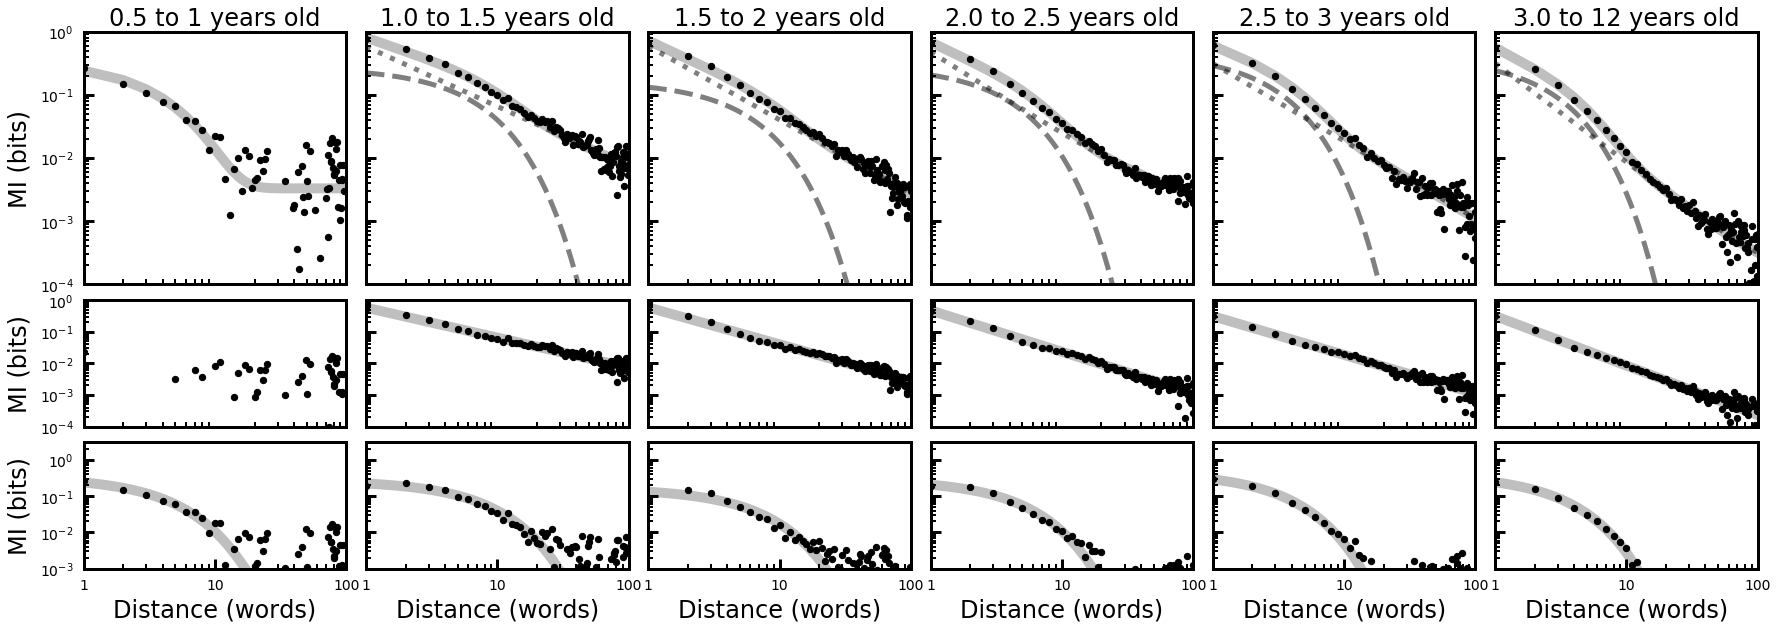

In [55]:
yoff=-.20
ncols = 4
zoom = 5
hr = [1, 0.5, 0.5, 0.5]
nrows = np.ceil(len(MI_DF)/ncols).astype(int)
fig = plt.figure(figsize=(len(MI_DF)*zoom,np.sum(hr)*zoom)) 
gs = gridspec.GridSpec(ncols=len(MI_DF), nrows=4, height_ratios=hr) 

for axi, (idx, row) in enumerate(MI_DF.sort_values(by=['age_cohort_low']).iterrows()):
    color = 'k'#LCOL_DICT[row.language]
    ax0 = plt.subplot(gs[0,axi])
    ax = ax0
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    # get signal limits
    sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
    sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                    sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]
            
    if axi==0: 
            ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
            ax.yaxis.set_label_coords(yoff,0.5)
            
    # model data
    #row.concat_results.params.intercept = 0
    distances_model = np.logspace(0,np.log10(distances[-1]), base=10, num=1000)
    
    # plot real data
    ax.scatter(distances, sig, alpha = 1, s=40, color=color)  
    
    if row.bestfitmodel == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances)
        y_pow = mf.get_y(mf.powerlaw_decay, row.concat_results, distances_model)
        y_exp = mf.get_y(mf.exp_decay, row.concat_results, distances_model)
        y_pow_dat = mf.get_y(mf.powerlaw_decay, row.concat_results, distances)
        y_exp_dat = mf.get_y(mf.exp_decay, row.concat_results, distances)

         
        ax.plot(distances_model, y_pow, ls='dotted', color= 'k', lw=5, alpha=0.5)
        ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, ls='dashed', color= 'k', lw=5, alpha=0.5)
    elif row.bestfitmodel == 'exp':
        y_model = mf.get_y(mf.exp_decay, row.exp_results, distances)
    # plot modelled data
    ax.plot(distances, y_model, alpha = 0.25, lw=10, color=color)
    
    # plot powerlaw component
    ax1 = plt.subplot(gs[1,axi])
    ax = ax1
    if row.bestfitmodel == 'pow_exp':
        ax.plot(distances_model, y_pow-row.concat_results.params['intercept'].value, alpha = 0.25, lw=10, color=color)
        ax.scatter(distances, sig-y_exp_dat, alpha = 1, s=40, color=color)   
    elif row.bestfitmodel == 'exp':
        y_exp = mf.get_y(mf.exp_decay, row.exp_results, distances_model)
        y_exp_dat = mf.get_y(mf.exp_decay, row.exp_results, distances)
        ax.scatter(distances, sig-y_exp_dat, alpha = 1, s=40, color=color)   
    
    # plot exponential component
    ax2 = plt.subplot(gs[2,axi])
    ax = ax2
    
    if row.bestfitmodel == 'pow_exp':
        ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, alpha = 0.25, lw=10, color=color)
        ax.scatter(distances, sig-y_pow_dat, alpha = 1, s=40, color=color)   
    elif row.bestfitmodel == 'exp':
        ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, alpha = 0.25, lw=10, color=color)
        ax.scatter(distances, sig - row.exp_results.params['intercept'].value, alpha = 1, s=40, color=color)   
    
    
    ax.set_xlabel('Distance (words)', labelpad=5, fontsize=24)
    #print(row.language, distances[peak_of_interest])
    
    for ax in [ax1, ax2]:
        if axi==0: 
            ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
            ax.yaxis.set_label_coords(yoff,0.5)
    
    for ax in [ax0,ax1,ax2]:
        ax.set_xlim([distances[0], distances[-1]])
        sig_lims[0] = np.log(10e-6)#
        #ax.set_ylim(np.exp(sig_lims))
        ax.set_ylim([1e-4, 1])
        ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
        ax.tick_params(which='major', length=10, width =3)
        ax.tick_params(which='minor', length=5, width =2)
        ax.set_xscale( "log" , basex=10)
        ax.set_yscale( "log" , basey=10)
        ax.set_xticks([])
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(3)
            ax.spines[axis].set_color('k')
    ax2.set_xticks([1,10,100])
    ax2.set_xticklabels(['1','10','100'])
    
    ac_high = np.min([row.age_cohort_high, 12])
    aac_high = np.min([row.age_cohort_high, 4])
    
    if axi !=0:
        for ax in [ax0,ax1,ax2]:
            ax.yaxis.set_ticklabels([])
    
    ax0.set_title("{} to {} years old".format(row.age_cohort_low, ac_high), fontsize=24)
    
    ax2.set_ylim([10e-4, 3])
#plt.tight_layout()
gs.update(wspace=0.075, hspace=0.1)
save_fig(FIGURE_DIR/'childes_mi')